# 2D+ MOT Simulation  
Before we move onto simulating our system, let's compare with DOI: 10.1103/PhysRevA.74.023406.  
Physical Dimensions:  
1. glass cell: 16.4cm $\times$ 4cm $\times$ 4cm
2. beam size(horizontal): 96 mm (waist) $\times$ 9 mm (waist) / $\sigma^+ - \sigma^-$ configuration
3. differential tube: 2mm (diameter) for 1cm long / 3mm (diameter) for 3cm long
4. beam size(vertical): 9mm (waist) / linearly polarized

For ${}^{87}Rb$, detuning is $2\Gamma$,but I should double-check the remaining parts. (may differ by measurements)

In [1]:
from sympy.core.benchmarks.bench_arit import timeit_Add_x05
%load_ext autoreload
%autoreload 2
import sys, pylcp, h5py
print("python:", sys.executable)
print("pylcp type:", type(pylcp))
print("pylcp file:", getattr(pylcp, "__file__", "<no __file__ attr>"))
print("pylcp spec origin:", getattr(pylcp, "__spec__", None) and pylcp.__spec__.origin)
print("pylcp path:", getattr(pylcp, "__path__", None))

python: /opt/anaconda3/envs/MOT_workspace/bin/python
pylcp type: <class 'module'>
pylcp file: /Users/ohik/Documents/MOT_workspace/pylcp_fork/pylcp/__init__.py
pylcp spec origin: /Users/ohik/Documents/MOT_workspace/pylcp_fork/pylcp/__init__.py
pylcp path: ['/Users/ohik/Documents/MOT_workspace/pylcp_fork/pylcp']


In [36]:
# imports
import numpy as np
import pylcp
import matplotlib.pyplot as plt
import scipy.constants as cts
from jinja2 import pass_context

In [37]:
atom = pylcp.atom("87Rb")
# set unitless mass
mass = (atom.state[2].gamma*atom.mass)/(cts.hbar*(100*2*np.pi*atom.transition[1].k)**2)
print(mass)

804.3755599734405


## Feb 2 - 3 / 2026 Beam shapes / Add geometric constraints
While I was trying to run 2D MOT first, I realized that I have to make special beam shape (ellipse / retarding beam) and test whether pylcp actually takes this geometric information of beam for evaluating OBE, which I'm sure they can.  
To test this, I'll add elliptical and donut shapes as laserBeams and run optical molasses simulation using donut shape beam.  

~~Before we add pushing / retarding beam with geometrical constraints (differential tube hole), run 2DMOT first.  
*Assume our horizontal beam fully cover the glass cell.*~~ 

In [38]:
# set hamiltonian
det = -2
s = 1
def return_hamiltonian(Fl):
    Hg, Bgq = pylcp.hamiltonians.singleF(F=Fl, gF=0, muB=1)
    He, Beq = pylcp.hamiltonians.singleF(F=Fl+1, gF=1/(Fl+1), muB=1)
    # Check the muB unit. -> we set megneton as 1. convert when we interested physical value (force etc.)
    # How we can evaluate dipole matrix before we introduce the field? -> evaluate all polarizaiotn case
    dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(Fl,(Fl+1))
    hamiltonian = pylcp.hamiltonian(Hg, He, Bgq, Beq, dijq, mass = mass)
    return hamiltonian

hamiltonian = return_hamiltonian(2)



### Beam shaping test
 

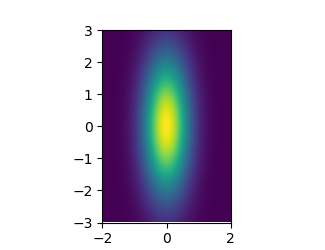

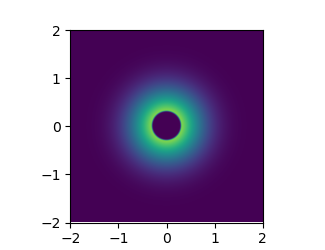

In [39]:
import pylcp.fields as fields
import numpy as np
import matplotlib.pyplot as plt

X, Y = np.meshgrid(np.linspace(-2, 2, 1001),
                   np.linspace(-2, 2, 1001))
Rt=np.array([X, Y, np.zeros(X.shape)])
tt=np.zeros(X.shape)

# example_beam = fields.gaussianBeam(kvec=np.array([0., 0., 1.]), pol=+1, s=5, delta=-2, wb=1)
# 
# plt.figure("Gaussian Beam", figsize=(3.25, 2.5))
# plt.clf()
# plt.imshow(example_beam.intensity(R=Rt,t=tt),
#            origin='lower',
#            extent=(-2, 2,
#                    -2, 2))
# plt.clim((0, 5))
# plt.set_cmap('viridis')

example_beam = fields.ellipticalgaussianBeam(kvec=np.array([0., 0., 1.]), pol=+1, s=5, delta=-2, wa=1, wb=2)

plt.figure("Elliptical Gaussian Beam", figsize=(3.25, 2.5))
plt.clf()
plt.imshow(example_beam.intensity(R=Rt,t=tt),
           origin='lower',
           extent=(-2, 2,
                   -3, 3))
plt.clim((0, 5))
plt.set_cmap('viridis')

example_beam = fields.donutBeam(kvec=np.array([0., 0., 1.]), pol=+1, s=5, delta=-2,h=0.3, wb=1)

plt.figure("Retarding Beam", figsize=(3.25, 2.5))
plt.clf()
plt.imshow(example_beam.intensity(R=Rt,t=tt),
           origin='lower',
           extent=(-2, 2,
                   -2, 2))
plt.clim((0, 5))
plt.set_cmap('viridis')

### 2D force profile / motion evolution
Now I got every beam shapes that I need for simulating our MOT. Test this from 2D optical molasses first.  
I'll draw force profile and evolve_position with gaussian - retarding beam pairs. expected force profile and position evolution is quite obvious.

KeyboardInterrupt: 

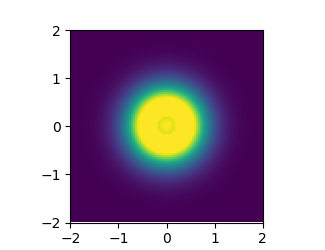

In [40]:
# 2D force profile.
# This example comes from the F=2->F'=3 1D molasses example and expand it.
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import pylcp.fields as fields
import scipy.constants as cts
from pylcp.common import progressBar
import lmfit

# Define atom here
atom = pylcp.atom("87Rb")
# This is our unitless mass
mass = (atom.state[2].gamma*atom.mass)/(cts.hbar*(100*2*np.pi*atom.transition[1].k)**2)

# beam geometries. points are unitless.

X, Y = np.meshgrid(np.linspace(-2, 2, 101),
                      np.linspace(-2, 2, 101))
Z = np.copy(X)
Rt=np.array([X, Y, Z])

example_beam1 = fields.gaussianBeam(kvec=np.array([0., 0., 1.]), pol=+1, s=5, delta=-2, wb=1)
example_beam2 = fields.donutBeam(kvec=np.array([0., 0., -1.]), pol=-1, s=5, delta =-2,h = 0.2, wb=1)
laserBeams = pylcp.laserBeams([example_beam1, example_beam2])

# Test plot for laserBeams.
plt.figure("test", figsize=(3.25, 2.5))
plt.clf()
plt.imshow(np.sum(laserBeams.intensity(R=Rt),axis=0),
           origin='lower',
           extent=(-2, 2,
                   -2, 2))
plt.clim((0, 5))
plt.set_cmap('viridis')

# Build Hamiltonian for Rb F2-F'3 transition
Hg, Bgq = pylcp.hamiltonians.singleF(F=2, gF=0, muB=1)
He, Beq = pylcp.hamiltonians.singleF(F=3, gF=1/3, muB=1)
dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(2, 3)
hamiltonian = pylcp.hamiltonian(Hg, He, Bgq, Beq, dijq, mass = mass)

# Zero magnetic field
magField = pylcp.constantMagneticField(np.array([0., 0., 0.]))

# Select solver
obe = pylcp.obe(laserBeams, magField, hamiltonian, include_mag_forces=False, transform_into_re_im=True)

# Double check why we need meshgrid
y_pts = np.linspace(-2, 2, 50)
vz_pts = np.linspace(0.05, 2, 50)

Y, Vz = np.meshgrid(y_pts,vz_pts)


obe.generate_force_profile(
    [np.zeros(np.shape(Y)), Y, np.zeros(np.shape(Y))],  
    [np.zeros(np.shape(Vz)), np.zeros(np.shape(Vz)), Vz],
    name='yz_plane_force', deltat_v=4, deltat_tmax=2*np.pi*5000, itermax=1000,
    rel=1e-8, abs=1e-10, progress_bar=True
)


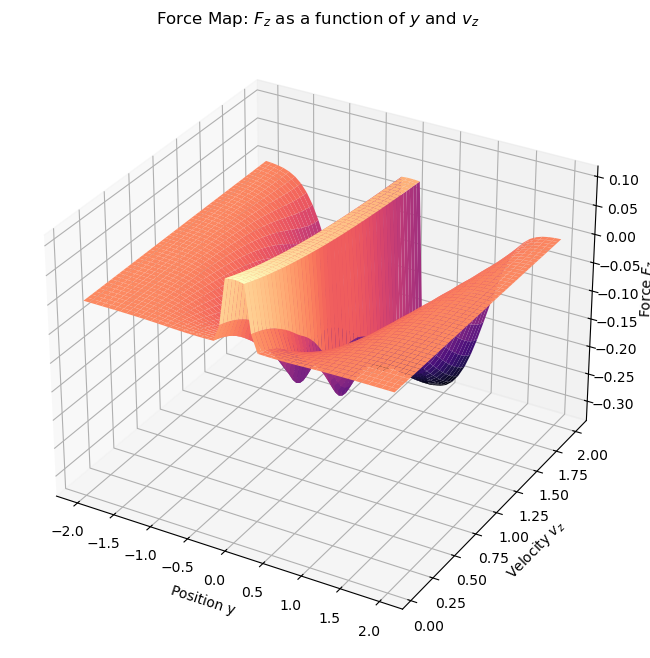

In [55]:
Fz_map = obe.profile['yz_plane_force'].F[2]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(Y, Vz, Fz_map, cmap='magma')

ax.set_xlabel('Position y')
ax.set_ylabel('Velocity $v_z$')
ax.set_zlabel('Force $F_z$')
plt.title('Force Map: $F_z$ as a function of $y$ and $v_z$')
plt.show()

This plot looks correct! Now save file.  
## Test hdf5 format

In [67]:
import h5py
import datetime

now = datetime.datetime.now()
formatted_now = now.strftime("%m-%d %H:%M")
file_name = formatted_now + "force profile test"
# profile attributes:
#   R : array_like, shape(3, ...)
#   V : array_like, shape(3, ...)
#   F : array_like, shape(3, ...)
#   f_mag : array_like, shape(3, ...) / Magnetic force at position R and velocity V
#   f : dictionary of array_like / The forces due to each laser.
#   fq : dictionary of array_like / The force due to each laser and its q component.
#   Neq : array_like / Equilibrium population found
print((obe.profile['yz_plane_force'].fq.keys()))
with h5py.File(file_name + '.hdf5', 'w') as f:
    profile = f.create_group('profile')
    profile.create_dataset('R',data=obe.profile['yz_plane_force'].R)
    profile.create_dataset('V',data=obe.profile['yz_plane_force'].V)
    profile.create_dataset('F',data=obe.profile['yz_plane_force'].F)
    profile.create_dataset('f_mag',data=obe.profile['yz_plane_force'].f_mag)
    # profile.create_dataset('f', data=obe.profile['yz_plane_force'].f)
    # profile.create_dataset('fq', data=obe.profile['yz_plane_force'].fq)
    # profile.create_dataset('Neq', data=obe.profile['yz_plane_force'].Neq)


dict_keys(['g->e'])


['profile']


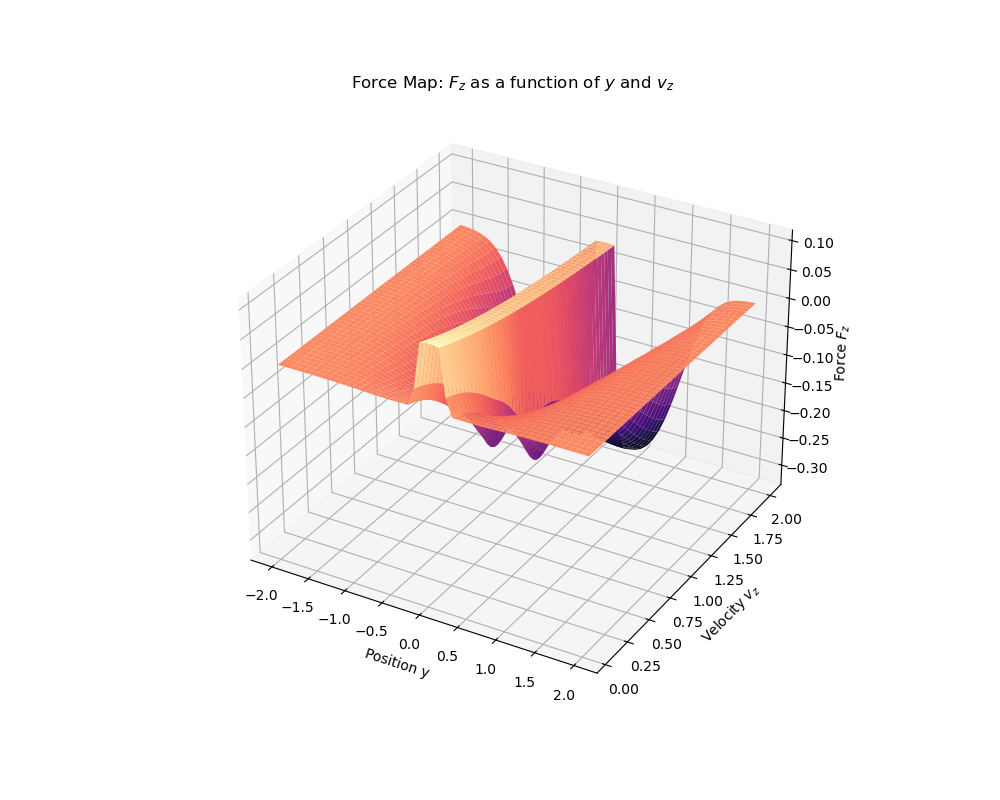

In [1]:
%matplotlib widget
import h5py
import matplotlib.pyplot as plt
with h5py.File('02-03 19:51force profile test.hdf5', 'r') as f:
    print(list(f.keys()))
    profile = f['profile']
    R = profile['R']
    V = profile['V']
    F = profile['F']
    Fz_map = F[2]
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.plot_surface(R[1], V[2], Fz_map, cmap='magma')
    
    ax.set_xlabel('Position y')
    ax.set_ylabel('Velocity $v_z$')
    ax.set_zlabel('Force $F_z$')
    plt.title('Force Map: $F_z$ as a function of $y$ and $v_z$')
    plt.show()

Since we tested wheter pylcp take consider spatial beam shape information, now move onto build 2D MOT first.  
The goal for this part is that plotting right Energy level diagram on x-y plane
## Energy level diagram along x-y plane

Now with a real Rb atom hamiltonian, I should test the magnetic field and energy level diagram.  
Note that for the magnetic field, we don't have z axis component since it's 2D. 
However, since we diagonalize along z component, we rotate magnetic field for plotting energy level diagram.

In [12]:
# Define Hamiltonian
%matplotlib widget

import numpy as np
import pylcp 
import pylcp.fields as fields
import scipy.constants as cts
import matplotlib.pyplot as plt

atom = pylcp.atom("87Rb")
# Set unitless mass
mass = (atom.state[2].gamma*atom.mass)/(cts.hbar*(100*2*np.pi*atom.transition[1].k)**2)

det = -2.0
s = 1.0
H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[0].J, atom.I, atom.state[0].gJ, atom.gI,
    atom.state[0].Ahfs/atom.state[2].gammaHz, Bhfs=0, Chfs=0,
    muB=1)

H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[2].J, atom.I, atom.state[2].gJ, atom.gI,
    Ahfs=atom.state[2].Ahfs/atom.state[2].gammaHz,
    Bhfs=atom.state[2].Bhfs/atom.state[2].gammaHz, Chfs=0,
    muB=1)

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(
    atom.state[0].J, atom.state[2].J, atom.I)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))

hamiltonian_D2 = pylcp.hamiltonian(H_g_D2, H_e_D2, mu_q_g_D2, mu_q_e_D2, dijq_D2, mass = mass)
hamiltonian_D2.print_structure()
print(E_e_D2)
print(E_g_D2)
# mF level indexing is basically assending order
hamiltonian_D2.return_full_H(np.array([0., 0., 0.]), np.array([0., 0., 0.]))

[[((<g|H_0|g> 8x8), (<g|mu_q|g> 8x8)) (<g|d_q|e> 8x16)]
 [(<e|d_q|g> 16x8) ((<e|H_0|e> 16x16), (<e|mu_q|e> 16x16))]]
[-49.793266   -37.88832803 -12.01855264  31.93585904]
[-704.13510208  422.48106125]


array([[-704.13510208+0.j,    0.        +0.j,    0.        +0.j,
           0.        +0.j,    0.        +0.j,    0.        +0.j,
           0.        +0.j,    0.        +0.j,    0.        +0.j,
           0.        +0.j,    0.        +0.j,    0.        +0.j,
           0.        +0.j,    0.        +0.j,    0.        +0.j,
           0.        +0.j,    0.        +0.j,    0.        +0.j,
           0.        +0.j,    0.        +0.j,    0.        +0.j,
           0.        +0.j,    0.        +0.j,    0.        +0.j],
       [   0.        +0.j, -704.13510208+0.j,    0.        +0.j,
           0.        +0.j,    0.        +0.j,    0.        +0.j,
           0.        +0.j,    0.        +0.j,    0.        +0.j,
           0.        +0.j,    0.        +0.j,    0.        +0.j,
           0.        +0.j,    0.        +0.j,    0.        +0.j,
           0.        +0.j,    0.        +0.j,    0.        +0.j,
           0.        +0.j,    0.        +0.j,    0.        +0.j,
           0.        +0.

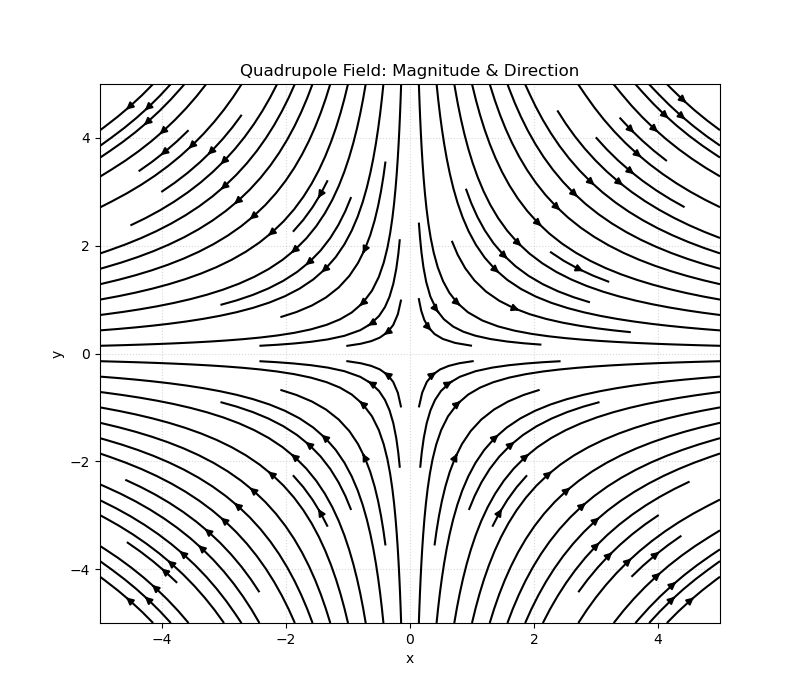

In [14]:
# Define magnetic field 
import pylcp
import numpy as np
import matplotlib.pyplot as plt

alpha = 1e-3 
magfield = pylcp.quadrupoleMagneticField2D(alpha)

x_vec = np.linspace(-5, 5, 50)
y_vec = np.linspace(-5, 5, 50)
x, y = np.meshgrid(x_vec, y_vec)
R = np.array([x,y, np.zeros_like(x)])

# B_mag = magfield.FieldMag(R)
# field gradient
Bx = 1 * x
By = -1 * y

plt.figure(figsize=(8, 7))

# cp = plt.quiver(x, y, B_mag)

plt.streamplot(x_vec, y_vec, Bx, By, color='black', density=1.2)

plt.title("Quadrupole Field: Magnitude & Direction")
plt.xlabel("x"); plt.ylabel("y")
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()
# Set obe
obe = pylcp.obe(laserBeams_D2, magfield, hamiltonian_D2, include_mag_forces=True, transform_into_re_im=True)

Check the energy levels are shifted accordingly.

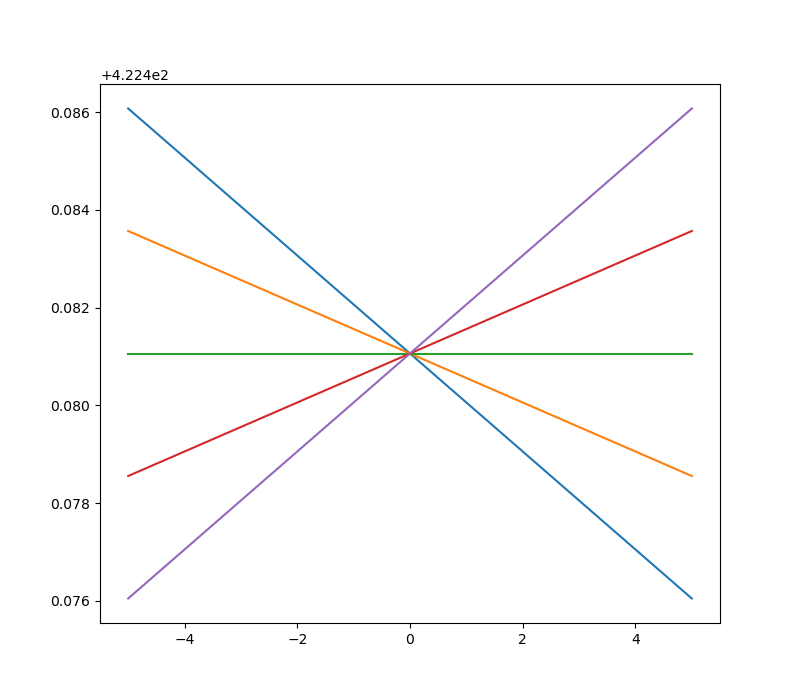

In [15]:
plt.figure(figsize=(8, 7))
axis_scanning = np.linspace(-5.0, 5.0, 50)
off_axis_scannig = np.zeros_like(np.linspace(-5.0, 5.0, 50))
# For checking dimension / values 
# x, y, z = np.meshgrid(np.arange(-5.0, 5.01, 0.25),np.arange(-5.0, 5.01, 0.25),np.arange(-5.0, 5.01, 0.25))
# Bq = magfield.Field([x,y,z])
# fig, ax = plt.subplots(3, 2, figsize=(6.5, 3*2.25))
# Bq_x = magfield.Field([axis_scanning,off_axis_scannig,off_axis_scannig])

# Plotting energy level for F=2, F'=3
# F=2 first
Es = np.zeros((axis_scanning.size, 5))
all_B = magfield.Field([axis_scanning,off_axis_scannig,off_axis_scannig])
# Realized that conventionally we set quantization axis along z axis. (including our hamiltonian)
# So simply plug in this 
for idx in range(axis_scanning.size):
    B_mag = all_B[0, idx]
    # Why we need to give them in this configuration? -> they use spherical basis for .return_full_H!
    Bq_vec = np.array([0,B_mag,0])
    H_full = hamiltonian_D2.return_full_H({}, Bq_vec)
    Es[idx, :] = np.real(np.diag(H_full))[3:8] 
plt.plot(axis_scanning, Es)
plt.show()

## MOT trapping test

Let's test MOT trapping and cooling effect in 2D MOT situation.  
*NOTE: I haven't take care much on units here. The goal of here is trying to test when we put everything.*

Completed in 48.73 s.                                               
Completed in 48.64 s.                                               
Completed in 4.10 s.                                                  


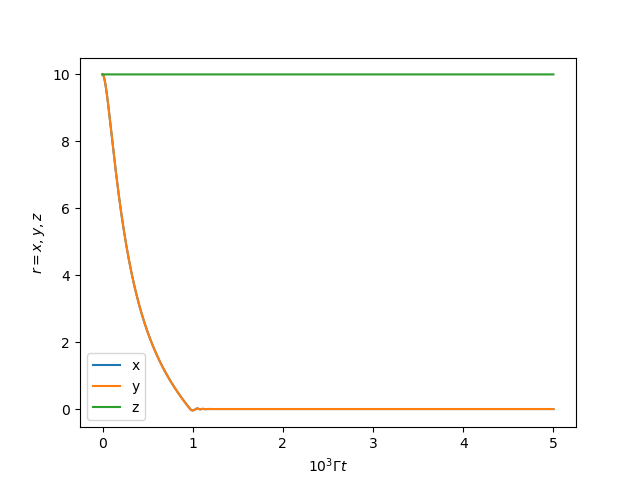

In [47]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import pylcp

det = -2.0
s = 1.
alpha = 1e-3
# define hamiltonian first
atom = pylcp.atom('87Rb')

H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[0].J, atom.I, atom.state[0].gJ, atom.gI,
    atom.state[0].Ahfs/atom.state[2].gammaHz, Bhfs=0, Chfs=0,
    muB=1)

H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[2].J, atom.I, atom.state[2].gJ, atom.gI,
    Ahfs=atom.state[2].Ahfs/atom.state[2].gammaHz,
    Bhfs=atom.state[2].Bhfs/atom.state[2].gammaHz, Chfs=0,
    muB=1)

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(
    atom.state[0].J, atom.state[2].J, atom.I)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))

hamiltonian_D2 = pylcp.hamiltonian(H_g_D2, H_e_D2, mu_q_g_D2, mu_q_e_D2, dijq_D2)

det_cooling = E_e_D2[3]-E_g_D2[1]+det # F:2->F':3
det_repumping = E_e_D2[2]-E_g_D2[0] # F:1->F':2


# Define beam here

laserBeams = {}

laserBeams_cooling_D2_x = pylcp.laserBeams([
{'kvec':np.array([1., 0., 0.]), 'pol':+1, 'delta':det_cooling, 's':s, 'wa':1e3, 'wb':2e3},
{'kvec':np.array([-1., 0., 0.]), 'pol':+1, 'delta':det_cooling, 's':s, 'wa':1e3, 'wb':2e3}
], beam_type=pylcp.ellipticalgaussianBeam)

laserBeams_repumping_D2_x = pylcp.laserBeams([
{'kvec':np.array([1., 0., 0.]), 'pol':+1, 'delta':det_repumping, 's':s, 'wa':1e3, 'wb':2e3},
{'kvec':np.array([-1., 0., 0.]), 'pol':+1, 'delta':det_repumping, 's':s, 'wa':1e3, 'wb':2e3}
], beam_type=pylcp.ellipticalgaussianBeam)
laserBeams['x'] = laserBeams_cooling_D2_x + laserBeams_repumping_D2_x

laserBeams_cooling_D2_y = pylcp.laserBeams([
{'kvec':np.array([0., 1., 0.]), 'pol':-1, 'delta':det_cooling, 's':s, 'wa':1e3, 'wb':2e3},
{'kvec':np.array([0., -1., 0.]), 'pol':-1, 'delta':det_cooling, 's':s, 'wa':1e3, 'wb':2e3}
], beam_type=pylcp.ellipticalgaussianBeam)

laserBeams_repumping_D2_y = pylcp.laserBeams([
{'kvec':np.array([0., 1., 0.]), 'pol':-1, 'delta':det_repumping, 's':s, 'wa':1e3, 'wb':2e3},
{'kvec':np.array([0., -1., 0.]), 'pol':-1, 'delta':det_repumping, 's':s, 'wa':1e3, 'wb':2e3}
], beam_type=pylcp.ellipticalgaussianBeam)
laserBeams['y'] = laserBeams_cooling_D2_y + laserBeams_repumping_D2_y

# s=0 will break simul
laserBeams_cooling_D2_z = pylcp.laserBeams([
{'kvec':np.array([0., 0., 1.]), 'pol':0, 'delta':det_cooling, 's':1e-4, 'wa':1e3, 'wb':2e3},
{'kvec':np.array([0., 0., -1.]), 'pol':0, 'delta':det_cooling, 's':1e-4, 'wa':1e3, 'wb':2e3}
], beam_type=pylcp.ellipticalgaussianBeam)

laserBeams_repumping_D2_z = pylcp.laserBeams([
{'kvec':np.array([0., 0., 1.]), 'pol':0, 'delta':det_repumping, 's':1e-4, 'wa':1e3, 'wb':2e3},
{'kvec':np.array([0., 0., -1.]), 'pol':0, 'delta':det_repumping, 's':1e-4, 'wa':1e3, 'wb':2e3}
], beam_type=pylcp.ellipticalgaussianBeam)
laserBeams['z'] = laserBeams_cooling_D2_z + laserBeams_repumping_D2_z

magfield = pylcp.quadrupoleMagneticField2D(alpha)

# set solver here
# due to the computation time, seperate as axis

rateeq = {}
rateeq['x'] = pylcp.rateeq(laserBeams['x'], magfield, hamiltonian_D2, include_mag_forces=True)
rateeq['y'] = pylcp.rateeq(laserBeams['y'], magfield, hamiltonian_D2, include_mag_forces=True)
rateeq['z'] = pylcp.rateeq(laserBeams['z'], magfield, hamiltonian_D2, include_mag_forces=True)
for key in rateeq:
    if key == 'x':
        ii = 0
    elif key == 'y':
        ii = 1
    elif key == 'z':
        ii = 2

# If I put r0 just np.zeros((3,)), error. how this fix the issue...?
    r0 = 1*np.zeros((3,))
# Placing atom at 0.,0.,0. break simul. (singular mag point)
    if ii == 2:
        r0 = np.array([10.,10.,10.])
    else:
        r0[ii] = 10.

    rateeq[key].set_initial_position(r0)
    rateeq[key].set_initial_velocity(np.zeros((3,)))

    Neq = rateeq[key].equilibrium_populations(r0, np.zeros(3),0.)
    rateeq[key].set_initial_pop(Neq)
    freeze_axis = [True]*3
    freeze_axis[ii] = False

    rateeq[key].evolve_motion([0, 5e3],
                           freeze_axis=freeze_axis,
                            atol = 1e-7, rtol = 1e-5,
                           progress_bar=True,
                           events = ()
                          )

fig, ax = plt.subplots(1, 1)
for key in rateeq:
    if key == 'x':
        ii = 0
    elif key == 'y':
        ii = 1
    elif key == 'z':
        ii = 2

    ax.plot(rateeq[key].sol.t/1e3, rateeq[key].sol.r[ii], label=key)

ax.legend()
ax.set_xlabel('$10^3 \Gamma t$')
ax.set_ylabel('$r=x,y,z$');

Why some example use unitless mass and some exmaple use it?  
Full atom -> computation is expensive. => maybe two level? then how about the RWA?  
언제 rateeq 언제 obe?


## Realistic 2DMOT atomic motion in 3D  
Now, we're simulaitng atoms posed in 2DMOT and draw 1) movie of atomic motion 2) phase diagrams  
Here, we'll use rateeq method and keep units as pylcp recommended unit system.

In [5]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import pylcp
from matplotlib.animation import FuncAnimation

det = -2.0
s = 1.
alpha = 1e-3
# define hamiltonian first
atom = pylcp.atom('87Rb')

H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[0].J, atom.I, atom.state[0].gJ, atom.gI,
    atom.state[0].Ahfs/atom.state[2].gammaHz, Bhfs=0, Chfs=0,
    muB=1)

H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[2].J, atom.I, atom.state[2].gJ, atom.gI,
    Ahfs=atom.state[2].Ahfs/atom.state[2].gammaHz,
    Bhfs=atom.state[2].Bhfs/atom.state[2].gammaHz, Chfs=0,
    muB=1)

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(
    atom.state[0].J, atom.state[2].J, atom.I)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))

hamiltonian_D2 = pylcp.hamiltonian(H_g_D2, H_e_D2, mu_q_g_D2, mu_q_e_D2, dijq_D2)

det_cooling = E_e_D2[3]-E_g_D2[1]+det # F:2->F':3
det_repumping = E_e_D2[2]-E_g_D2[0] # F:1->F':2


# Define beam here

laserBeams = {}

laserBeams_cooling_D2_x = pylcp.laserBeams([
{'kvec':np.array([1., 0., 0.]), 'pol':+1, 'delta':det_cooling, 's':s, 'wa':1e3, 'wb':2e3},
{'kvec':np.array([-1., 0., 0.]), 'pol':+1, 'delta':det_cooling, 's':s, 'wa':1e3, 'wb':2e3}
], beam_type=pylcp.ellipticalgaussianBeam)

laserBeams_repumping_D2_x = pylcp.laserBeams([
{'kvec':np.array([1., 0., 0.]), 'pol':+1, 'delta':det_repumping, 's':s, 'wa':1e3, 'wb':2e3},
{'kvec':np.array([-1., 0., 0.]), 'pol':+1, 'delta':det_repumping, 's':s, 'wa':1e3, 'wb':2e3}
], beam_type=pylcp.ellipticalgaussianBeam)
laserBeams['x'] = laserBeams_cooling_D2_x + laserBeams_repumping_D2_x

laserBeams_cooling_D2_y = pylcp.laserBeams([
{'kvec':np.array([0., 1., 0.]), 'pol':-1, 'delta':det_cooling, 's':s, 'wa':1e3, 'wb':2e3},
{'kvec':np.array([0., -1., 0.]), 'pol':-1, 'delta':det_cooling, 's':s, 'wa':1e3, 'wb':2e3}
], beam_type=pylcp.ellipticalgaussianBeam)

laserBeams_repumping_D2_y = pylcp.laserBeams([
{'kvec':np.array([0., 1., 0.]), 'pol':-1, 'delta':det_repumping, 's':s, 'wa':1e3, 'wb':2e3},
{'kvec':np.array([0., -1., 0.]), 'pol':-1, 'delta':det_repumping, 's':s, 'wa':1e3, 'wb':2e3}
], beam_type=pylcp.ellipticalgaussianBeam)
laserBeams['y'] = laserBeams_cooling_D2_y + laserBeams_repumping_D2_y

# s=0 will break simul
laserBeams_cooling_D2_z = pylcp.laserBeams([
{'kvec':np.array([0., 0., 1.]), 'pol':0, 'delta':det_cooling, 's':1e-4, 'wa':1e3, 'wb':2e3},
{'kvec':np.array([0., 0., -1.]), 'pol':0, 'delta':det_cooling, 's':1e-4, 'wa':1e3, 'wb':2e3}
], beam_type=pylcp.ellipticalgaussianBeam)

laserBeams_repumping_D2_z = pylcp.laserBeams([
{'kvec':np.array([0., 0., 1.]), 'pol':0, 'delta':det_repumping, 's':1e-4, 'wa':1e3, 'wb':2e3},
{'kvec':np.array([0., 0., -1.]), 'pol':0, 'delta':det_repumping, 's':1e-4, 'wa':1e3, 'wb':2e3}
], beam_type=pylcp.ellipticalgaussianBeam)
laserBeams['z'] = laserBeams_cooling_D2_z + laserBeams_repumping_D2_z

magfield = pylcp.quadrupoleMagneticField2D(alpha)

# set solver here
# due to the computation time, seperate as axis

rateeq = pylcp.rateeq(laserBeams['x'] + laserBeams['y'] + laserBeams['z'], magfield, hamiltonian_D2, include_mag_forces=True)

r0 = np.array([10.,10.,10.])
rateeq.set_initial_position(r0)
rateeq.set_initial_velocity(np.zeros((3,)))

Neq = rateeq.equilibrium_populations(r0, np.zeros(3),0.)
print(Neq)
rateeq.set_initial_pop(Neq)


rateeq.evolve_motion([0, 5e3],
                    atol = 1e-7, rtol = 1e-5,
                    freeze_axis = [False,False,True],
                    progress_bar=True,
                    events = ()
                    )



[4.88732779e-05 4.90003513e-05 4.94617054e-05 2.24054030e-01
 1.74564681e-01 1.61054358e-01 1.72060965e-01 2.17693915e-01
 5.74467440e-09 1.27270824e-06 1.01260444e-06 1.24415086e-06
 1.95812425e-05 1.87951142e-05 1.82321798e-05 1.86453464e-05
 1.92826525e-05 9.58730659e-03 7.11504851e-03 6.04641545e-03
 5.69837867e-03 5.93776280e-03 6.86179937e-03 9.07993301e-03]
Completed in 1:16.                                                  


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  8.959e-02 ...  5.000e+03  5.000e+03]
      sol: None
 t_events: []
 y_events: []
     nfev: 140696
     njev: 0
      nlu: 0
        N: [[ 4.887e-05  4.887e-05 ...  4.911e-05  4.911e-05]
            [ 4.900e-05  4.900e-05 ...  4.898e-05  4.898e-05]
            ...
            [ 6.862e-03  6.862e-03 ...  6.988e-03  6.988e-03]
            [ 9.080e-03  9.080e-03 ...  9.331e-03  9.331e-03]]
        v: [[ 0.000e+00 -6.004e-05 ...  4.880e-05  2.992e-05]
            [ 0.000e+00 -6.004e-05 ...  4.880e-05  2.992e-05]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]]
        r: [[ 1.000e+01  1.000e+01 ...  6.193e-06  8.929e-06]
            [ 1.000e+01  1.000e+01 ...  6.193e-06  8.929e-06]
            [ 1.000e+01  1.000e+01 ...  1.000e+01  1.000e+01]]

Let's plot this for fun
(just used gpt for this part)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, writers, FFMpegWriter

def animate_traj_fast(t, r, trail=200, interval=20, step=1, save_path=None,
                      show=True, close_fig=True, dpi=120):
    t = np.asarray(t)
    r = np.asarray(r)
    x, y, z = r[:, 0], r[:, 1], r[:, 2]
    N = len(t)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.set_title("3D Trajectory")
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")  
    
    pad = 0.05
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    zmin, zmax = z.min(), z.max()
    dx, dy, dz = xmax-xmin, ymax-ymin, zmax-zmin

    def lim(lo, hi, d):
        if d == 0:
            eps = 1e-9 if lo == 0 else 1e-6 * abs(lo)
            return lo - eps, hi + eps
        return lo - pad*d, hi + pad*d

    ax.set_xlim(*lim(xmin, xmax, dx))
    ax.set_ylim(*lim(ymin, ymax, dy))
    ax.set_zlim(*lim(zmin, zmax, dz))

    (line,) = ax.plot([], [], [], lw=1.5)
    (pt,) = ax.plot([], [], [], marker="o", markersize=5)

    frames = range(0, N, step)   

    def init():
        line.set_data([], [])
        line.set_3d_properties([])
        pt.set_data([], [])
        pt.set_3d_properties([])
        return line, pt

    def update(i):
        if trail is None:
            i0 = 0
        else:
            i0 = max(0, i - int(trail))
        line.set_data(x[i0:i+1], y[i0:i+1])
        line.set_3d_properties(z[i0:i+1])
        pt.set_data([x[i]], [y[i]])
        pt.set_3d_properties([z[i]])
        return line, pt

    ani = FuncAnimation(
        fig, update, frames=frames, init_func=init,
        interval=interval, blit=False,
        cache_frame_data=False  
    )

    if save_path:
        fps = max(1, int(1000/interval))

        if save_path.lower().endswith(".mp4"):
            if writers.is_available("ffmpeg"):
                ani.save(save_path, writer=FFMpegWriter(fps=fps), dpi=dpi)
            else:
                gif_path = save_path[:-4] + ".gif"
                ani.save(gif_path, writer="pillow", fps=fps, dpi=dpi)
                print(f"[ffmpeg 없음] mp4 대신 gif 저장: {gif_path}")

        elif save_path.lower().endswith(".gif"):
            ani.save(save_path, writer="pillow", fps=fps, dpi=dpi)

    if show:
        plt.show()

    if close_fig:
        plt.close(fig)  

    return ani

ani = animate_traj_fast(rateeq.sol.t, np.column_stack([rateeq.sol.r[0], rateeq.sol.r[1], rateeq.sol.r[2]]), trail=80, interval=20, step=2, save_path="traj.mp4", dpi=120)


Now, let's simulate for unconstrained situation, but follow units.  
Pylcp use unit length, time, magnetic field, and mass.  
"... For pylcp, $\hbar = 1$ so that angular frequencies and energies are equivalent. Thus the user speicifies $\hat{H}/\hbar$, rather than $\hat{H}$.  
For other quantities, we speicifically seperate out the units, with dimensionless numbers denoted with a bar.  
Hamiltonian using the hamiltonian class, the user has the ability to set the units by speicifying base units of length $x_0$, time $t_0$, magnetic field $B_0$ and mass $m$."  
time is in 1/$\gamma$ scale. So If we want to simulate up to 10ms, time should be around 62500. -> use 7e4  
distance is in 1/$k$ scale. In our case, 1m ~ 1.3e6.   
Bohr magneton initial value is CODATA vlaue in Hz/G.(~1.399e6 Hz/G)  
It's better choice to keep Bohr magneton as CODATA but alpha = $B(G/cm) \times 100 \times muB / (\gamma/(2\times \pi)\times k)$


 

In [8]:
%matplotlib widget
import sampling
import Boltzmann_dist
import numpy as np
import scipy.constants as cts
import matplotlib.pyplot as plt
import pylcp
from matplotlib.animation import FuncAnimation

# Unit definition
# Note: k is defined in cm.
atom = pylcp.atom('87Rb')
mass = (atom.state[2].gamma*atom.mass)/(cts.hbar*(100*2*np.pi*atom.transition[1].k)**2)
klab = 2 * np.pi * atom.transition[1].k # Lab wave vector
taulab = atom.state[2].tau
gammalab = 1/taulab
Blab = 15 #G/cm
x0 = 1/klab # cm
t0 = klab * x0 * taulab # s
k = klab * x0
gamma = gammalab * t0
alpha = cts.value('Bohr magneton') * 1e-4 * Blab * x0 * t0/cts.hbar
tlen = 1e-2 / t0
wa = 1 / x0
wb = 10 / x0
det = -2.0
s = 1.
print(f"mass = {mass}")
print(f"tlen = {tlen}")
print(f"wa = {wa}")
print(f"wb = {wb}")
print(f"alpha = {alpha}")




H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[0].J, atom.I, atom.state[0].gJ, atom.gI,
    atom.state[0].Ahfs/atom.state[2].gammaHz, Bhfs=0, Chfs=0, muB = 1)

H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[2].J, atom.I, atom.state[2].gJ, atom.gI,
    Ahfs=atom.state[2].Ahfs/atom.state[2].gammaHz,
    Bhfs=atom.state[2].Bhfs/atom.state[2].gammaHz, Chfs=0, muB = 1)

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(
    atom.state[0].J, atom.state[2].J, atom.I)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))

hamiltonian_D2 = pylcp.hamiltonian(H_g_D2, H_e_D2, mu_q_g_D2, mu_q_e_D2, dijq_D2, mass = mass)

det_cooling = E_e_D2[3]-E_g_D2[1]+det # F:2->F':3
det_repumping = E_e_D2[2]-E_g_D2[0] # F:1->F':2


# Define beam here

laserBeams = {}

laserBeams_cooling_D2_x = pylcp.laserBeams([
{'kvec':np.array([1., 0., 0.]), 'pol':+1, 'delta':det_cooling, 's':s, 'wa':wa, 'wb':wb},
{'kvec':np.array([-1., 0., 0.]), 'pol':+1, 'delta':det_cooling, 's':s, 'wa':wa, 'wb':wb}
], beam_type=pylcp.ellipticalgaussianBeam)

laserBeams_repumping_D2_x = pylcp.laserBeams([
{'kvec':np.array([1., 0., 0.]), 'pol':+1, 'delta':det_repumping, 's':s, 'wa':wa, 'wb':wb},
{'kvec':np.array([-1., 0., 0.]), 'pol':+1, 'delta':det_repumping, 's':s, 'wa':wa, 'wb':wb}
], beam_type=pylcp.ellipticalgaussianBeam)
laserBeams['x'] = laserBeams_cooling_D2_x + laserBeams_repumping_D2_x

laserBeams_cooling_D2_y = pylcp.laserBeams([
{'kvec':np.array([0., 1., 0.]), 'pol':-1, 'delta':det_cooling, 's':s, 'wa':wa, 'wb':wb},
{'kvec':np.array([0., -1., 0.]), 'pol':-1, 'delta':det_cooling, 's':s, 'wa':wa, 'wb':wb}
], beam_type=pylcp.ellipticalgaussianBeam)

laserBeams_repumping_D2_y = pylcp.laserBeams([
{'kvec':np.array([0., 1., 0.]), 'pol':-1, 'delta':det_repumping, 's':s, 'wa':wa, 'wb':wb},
{'kvec':np.array([0., -1., 0.]), 'pol':-1, 'delta':det_repumping, 's':s, 'wa':wa, 'wb':wb}
], beam_type=pylcp.ellipticalgaussianBeam)
laserBeams['y'] = laserBeams_cooling_D2_y + laserBeams_repumping_D2_y

magfield = pylcp.quadrupoleMagneticField2D(alpha)

# set solver here

rateeq = pylcp.rateeq(laserBeams['x'] + laserBeams['y'], magfield, hamiltonian_D2, include_mag_forces=True, svd_eps = 1e-14)

r0 = sampling.sampling(x_limit = 10, y_limit = 10, z_limit = 0, Natom = 1, fixed_plane = 'xy')
rateeq.set_initial_position(r0)
# v0 = Boltzmann_dist.vel_Boltzmann(T = 300, m = atom.mass, fixed_plane = 'xy')
# Set velocity as unitless.
# v0 = v0*atom.transition[1].k/atom.state[2].gamma
v0 = np.zeros(3)
rateeq.set_initial_velocity(v0)

# uniform over ground manifold as a sane start:
N0 = np.zeros(rateeq.hamiltonian.n)
ng = rateeq.hamiltonian.ns[0]          # ground manifold size (usually first block)
N0[:ng] = 1/ng
rateeq.set_initial_pop(N0)

sol = rateeq.evolve_populations([0, 5e3], rtol=1e-6, atol=1e-9)  # time in pylcp units
Nss = sol.y[:, -1]
Nss /= Nss.sum()
rateeq.set_initial_pop(Nss)


rateeq.evolve_motion([0, tlen],
                    atol = 1e-7, rtol = 1e-5,
                    freeze_axis = [False,False,True],
                    progress_bar=True,
                    events = ()
                    )


mass = 804.3755599734405
tlen = 381173.09832741244
wa = 80528.75481555492
wb = 805287.5481555491
alpha = 4.2974361699703885e-05
Completed in 10:45.                                                 


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  6.966e-01 ...  3.812e+05  3.812e+05]
      sol: None
 t_events: []
 y_events: []
     nfev: 1403912
     njev: 0
      nlu: 0
        N: [[ 4.911e-05  4.911e-05 ...  4.933e-05  4.937e-05]
            [ 4.898e-05  4.898e-05 ...  4.911e-05  4.914e-05]
            ...
            [ 6.987e-03  6.987e-03 ...  6.989e-03  6.989e-03]
            [ 9.329e-03  9.329e-03 ...  9.332e-03  9.332e-03]]
        v: [[ 0.000e+00  7.296e-09 ... -2.597e-08 -7.678e-08]
            [ 0.000e+00 -2.195e-08 ... -1.403e-07 -1.430e-07]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]]
        r: [[-1.277e+00 -1.277e+00 ...  1.827e-04  1.826e-04]
            [ 3.842e+00  3.842e+00 ...  9.874e-06  9.596e-06]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]]

In [9]:
#initial velocity
print(f"Initial velocity is(in unitless) {np.sqrt(rateeq.sol.r[0,0]**2+rateeq.sol.r[1,0]**2+rateeq.sol.r[2,0]**2)}") 

print(f"Final velocity is(in unitless) {np.sqrt(rateeq.sol.r[0,-1]**2+rateeq.sol.r[1,-1]**2+rateeq.sol.r[2,-1]**2)}")


Initial velocity is(in unitless) 4.048711283761615
Final velocity is(in unitless) 0.00018281952016561528


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, writers, FFMpegWriter

def animate_traj_2d(t, r_xy, trail=200, interval=20, step=1,
                    save_path=None, show=True, close_fig=True, dpi=120):
    t = np.asarray(t)
    r_xy = np.asarray(r_xy)
    x, y = r_xy[:, 0], r_xy[:, 1]
    N = len(t)

    fig, ax = plt.subplots()
    ax.set_title("2D Trajectory (x-y)")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_aspect("equal", adjustable="box")

    # axis limits (fixed)
    pad = 0.05
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    dx, dy = xmax-xmin, ymax-ymin
    def lim(lo, hi, d):
        if d == 0:
            eps = 1e-9 if lo == 0 else 1e-6 * abs(lo)
            return lo - eps, hi + eps
        return lo - pad*d, hi + pad*d

    ax.set_xlim(*lim(xmin, xmax, dx))
    ax.set_ylim(*lim(ymin, ymax, dy))

    (line,) = ax.plot([], [], lw=1.5)
    (pt,) = ax.plot([], [], marker="o", markersize=5)

    frames = range(0, N, step)

    def init():
        line.set_data([], [])
        pt.set_data([], [])
        return line, pt

    def update(i):
        i0 = 0 if trail is None else max(0, i - int(trail))
        line.set_data(x[i0:i+1], y[i0:i+1])
        pt.set_data([x[i]], [y[i]])
        return line, pt

    ani = FuncAnimation(
        fig, update, frames=frames, init_func=init,
        interval=interval, blit=True, 
        cache_frame_data=False
    )

    if save_path:
        fps = max(1, int(1000/interval))
        if save_path.lower().endswith(".mp4"):
            if writers.is_available("ffmpeg"):
                ani.save(save_path, writer=FFMpegWriter(fps=fps), dpi=dpi)
            else:
                gif_path = save_path[:-4] + ".gif"
                ani.save(gif_path, writer="pillow", fps=fps, dpi=dpi)
                print(f"[ffmpeg 없음] mp4 대신 gif 저장: {gif_path}")
        elif save_path.lower().endswith(".gif"):
            ani.save(save_path, writer="pillow", fps=fps, dpi=dpi)

    if show:
        plt.show()
    if close_fig:
        plt.close(fig)

    return ani
# Recover time to s, position to m.
t_s = rateeq.sol.t/(6e6)
scale = (2*np.pi/780e-9)
x = rateeq.sol.r[0]/scale
y = rateeq.sol.r[1]/scale

plt.close("all")
ani = animate_traj_2d(t_s, np.column_stack([x, y]),
                      trail=200, interval=20, step=50,
                      save_path="traj.mp4", dpi=120) 

The result is promising. Now I want to plot phase plane for 2D case.  
(consider move directly to 2D+MOT case? adding z dynamics with condition and evaluate only 2D plane will give a same result.)

## Add geometrical constraints  
To plot meaningful phase plane, I need to add 1) bouncing effect on the wall 2) and stop the evaluation when it pass through the differential hole.  
From the reference, they simulated the same number of atoms(!) given a pressure with considering collision effect which will be significant at  3*1e-7 mbar.  
What is the number of atom at 1*1e-7mbar from the ideal gas law? $PV = NKT$, P = 1*1e-5 Pascal, V = 0.0002624m^3, K = 1.38*1e-23 J * mol^-1 * K^-1 , T = 300K -> 1.9e+14  
I won't simulate 1.9e+14 atoms. (maximum 100 depends on the cluster performance.)

In [2]:
# Set params here:
%matplotlib widget
import sampling
import Boltzmann_dist
import numpy as np
import scipy.constants as cts
import matplotlib.pyplot as plt
import pylcp
from matplotlib.animation import FuncAnimation

# Unit definition
# Note: k is defined in cm.
atom = pylcp.atom('87Rb')
klab = 2 * np.pi * atom.transition[1].k # Lab wave vector
taulab = atom.state[2].tau
gammalab = 1/taulab
Blab = 15 #G/cm
x0 = 1/klab # cm
t0 = klab * x0 * taulab # s
k = klab * x0
gamma = gammalab * t0
alpha = cts.value('Bohr magneton') * 1e-4 * Blab * x0 * t0/cts.hbar
tlen = 1e-2 / t0
wa = 1 / x0
wb = 10 / x0
det = -2.0
s = 1.
mass = (atom.state[2].gamma*atom.mass)/(cts.hbar*(100*2*np.pi*atom.transition[1].k)**2)
print(f"mass = {mass}")
print(f"tlen = {tlen}")
print(f"wa = {wa}")
print(f"wb = {wb}")
print(f"alpha = {alpha}")




mass = 804.3755599734405
tlen = 381173.09832741244
wa = 80528.75481555492
wb = 805287.5481555491
alpha = 4.2974361699703885e-05


In [3]:
# Set Hamiltonian here
H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[0].J, atom.I, atom.state[0].gJ, atom.gI,
    atom.state[0].Ahfs/atom.state[2].gammaHz, Bhfs=0, Chfs=0, muB = 1)

H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[2].J, atom.I, atom.state[2].gJ, atom.gI,
    Ahfs=atom.state[2].Ahfs/atom.state[2].gammaHz,
    Bhfs=atom.state[2].Bhfs/atom.state[2].gammaHz, Chfs=0, muB = 1)

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(
    atom.state[0].J, atom.state[2].J, atom.I)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))

hamiltonian_D2 = pylcp.hamiltonian(H_g_D2, H_e_D2, mu_q_g_D2, mu_q_e_D2, dijq_D2, mass = mass)

det_cooling = E_e_D2[3]-E_g_D2[1]+det # F:2->F':3
det_repumping = E_e_D2[2]-E_g_D2[0] # F:1->F':2



In [4]:
# Set fields here
laserBeams = {}

laserBeams_cooling_D2_x = pylcp.laserBeams([
{'kvec':np.array([1., 0., 0.]), 'pol':+1, 'delta':det_cooling, 's':s, 'wa':wa, 'wb':wb},
{'kvec':np.array([-1., 0., 0.]), 'pol':+1, 'delta':det_cooling, 's':s, 'wa':wa, 'wb':wb}
], beam_type=pylcp.ellipticalgaussianBeam)

laserBeams_repumping_D2_x = pylcp.laserBeams([
{'kvec':np.array([1., 0., 0.]), 'pol':+1, 'delta':det_repumping, 's':s, 'wa':wa, 'wb':wb},
{'kvec':np.array([-1., 0., 0.]), 'pol':+1, 'delta':det_repumping, 's':s, 'wa':wa, 'wb':wb}
], beam_type=pylcp.ellipticalgaussianBeam)
laserBeams['x'] = laserBeams_cooling_D2_x + laserBeams_repumping_D2_x

laserBeams_cooling_D2_y = pylcp.laserBeams([
{'kvec':np.array([0., 1., 0.]), 'pol':-1, 'delta':det_cooling, 's':s, 'wa':wa, 'wb':wb},
{'kvec':np.array([0., -1., 0.]), 'pol':-1, 'delta':det_cooling, 's':s, 'wa':wa, 'wb':wb}
], beam_type=pylcp.ellipticalgaussianBeam)

laserBeams_repumping_D2_y = pylcp.laserBeams([
{'kvec':np.array([0., 1., 0.]), 'pol':-1, 'delta':det_repumping, 's':s, 'wa':wa, 'wb':wb},
{'kvec':np.array([0., -1., 0.]), 'pol':-1, 'delta':det_repumping, 's':s, 'wa':wa, 'wb':wb}
], beam_type=pylcp.ellipticalgaussianBeam)
laserBeams['y'] = laserBeams_cooling_D2_y + laserBeams_repumping_D2_y

magfield = pylcp.quadrupoleMagneticField2D(alpha)

In [7]:
# Set solver here
rateeq = pylcp.rateeq(laserBeams['x'] + laserBeams['y'], magfield, hamiltonian_D2, include_mag_forces=True, svd_eps = 1e-14)

# r0 = sampling.sampling(x_limit = 10, y_limit = 10, z_limit = 0, Natom = 1, fixed_plane = 'xy')
r0 = np.array([10,10,0])
rateeq.set_initial_position(r0)
v0 = Boltzmann_dist.vel_Boltzmann(T = 300, m = atom.mass, fixed_plane = 'xy')
# Set velocity as unitless.
v0 = v0 * t0 / x0
# v0 = np.zeros(3)
rateeq.set_initial_velocity(v0)

# uniform over ground manifold as a sane start:
N0 = np.zeros(rateeq.hamiltonian.n)
ng = rateeq.hamiltonian.ns[0]          # ground manifold size (usually first block)
N0[:ng] = 1/ng
rateeq.set_initial_pop(N0)

sol = rateeq.evolve_populations([0, 5e3], rtol=1e-6, atol=1e-9)  # time in pylcp units
Nss = sol.y[:, -1]
Nss /= Nss.sum()
rateeq.set_initial_pop(Nss)

rateeq.evolve_motion([0, tlen],
                    atol = 1e-7, rtol = 1e-5,
                    freeze_axis = [False,False,True],
                    progress_bar=True,
                    boundaries=[15, 15, 0]
                    )

Completed in 10:57.                                                 


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  8.981e-02 ...  3.812e+05  3.812e+05]
      sol: None
 t_events: [array([ 9.415e+01,  3.211e+02, ...,  1.367e+05,  1.755e+05],
                 shape=(148,)), array([ 2.074e+02,  4.352e+02, ...,  1.283e+05,  1.492e+05],
                 shape=(147,)), array([ 2.779e+01,  9.462e+01, ...,  1.622e+05,  1.813e+05],
                 shape=(463,)), array([ 6.118e+01,  1.281e+02, ...,  1.702e+05,  2.005e+05],
                 shape=(463,))]
 y_events: [array([[ 9.694e-05,  7.565e-05, ..., -1.458e+01,  0.000e+00],
                  [ 8.235e-05,  7.445e-05, ...,  7.196e+00,  0.000e+00],
                  ...,
                  [ 4.900e-05,  4.894e-05, ..., -3.555e-01,  0.000e+00],
                  [ 4.899e-05,  4.892e-05, ..., -6.684e-01,  0.000e+00]],
                 shape=(148, 30)), array([[ 8.527e-05,  7.588e-05, ...,  4.054e+00,  0.000e+00],
                

In [15]:
#initial velocity
print(f"Initial velocity is(in unitless) {np.sqrt(rateeq.sol.r[0,0]**2+rateeq.sol.r[1,0]**2+rateeq.sol.r[2,0]**2)}") 

print(f"Final velocity is(in unitless) {np.sqrt(rateeq.sol.r[0,-1]**2+rateeq.sol.r[1,-1]**2+rateeq.sol.r[2,-1]**2)}")


Initial velocity is(in unitless) 14.142135623730951
Final velocity is(in unitless) 0.1478072604725313


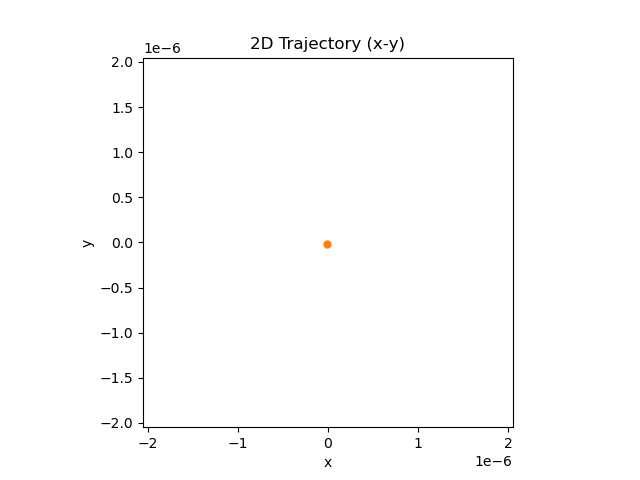

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, writers, FFMpegWriter

def animate_traj_2d(t, r_xy, trail=200, interval=20, step=1,
                    save_path=None, show=True, close_fig=True, dpi=120):
    t = np.asarray(t)
    r_xy = np.asarray(r_xy)
    x, y = r_xy[:, 0], r_xy[:, 1]
    N = len(t)

    fig, ax = plt.subplots()
    ax.set_title("2D Trajectory (x-y)")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_aspect("equal", adjustable="box")

    # axis limits (fixed)
    pad = 0.05
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    dx, dy = xmax-xmin, ymax-ymin
    def lim(lo, hi, d):
        if d == 0:
            eps = 1e-9 if lo == 0 else 1e-6 * abs(lo)
            return lo - eps, hi + eps
        return lo - pad*d, hi + pad*d

    ax.set_xlim(*lim(xmin, xmax, dx))
    ax.set_ylim(*lim(ymin, ymax, dy))

    (line,) = ax.plot([], [], lw=1.5)
    (pt,) = ax.plot([], [], marker="o", markersize=5)

    frames = range(0, N, step)

    def init():
        line.set_data([], [])
        pt.set_data([], [])
        return line, pt

    def update(i):
        i0 = 0 if trail is None else max(0, i - int(trail))
        line.set_data(x[i0:i+1], y[i0:i+1])
        pt.set_data([x[i]], [y[i]])
        return line, pt

    ani = FuncAnimation(
        fig, update, frames=frames, init_func=init,
        interval=interval, blit=True, 
        cache_frame_data=False
    )

    if save_path:
        fps = max(1, int(1000/interval))
        if save_path.lower().endswith(".mp4"):
            if writers.is_available("ffmpeg"):
                ani.save(save_path, writer=FFMpegWriter(fps=fps), dpi=dpi)
            else:
                gif_path = save_path[:-4] + ".gif"
                ani.save(gif_path, writer="pillow", fps=fps, dpi=dpi)
                print(f"[ffmpeg 없음] mp4 대신 gif 저장: {gif_path}")
        elif save_path.lower().endswith(".gif"):
            ani.save(save_path, writer="pillow", fps=fps, dpi=dpi)

    if show:
        plt.show()
    if close_fig:
        plt.close(fig)

    return ani
# Recover time to s, position to cm.
t_s = rateeq.sol.t * t0
x = rateeq.sol.r[0] * x0
y = rateeq.sol.r[1] * x0

plt.close("all")
ani = animate_traj_2d(t_s, np.column_stack([x, y]),
                      trail=200, interval=20, step=50,
                      save_path="traj.mp4", dpi=120) 

What should I do next? (from the group meeting)  
Plans todo:
1. add geometrical constraint
2. do multi-particle simulation and compare either macbook or HPC are better?
3. Set 100 atom simulation (with constraint, z beam) draw phase map
4. Calculate atomic density?
--- end of 2D+MOT. afer there, fine tuning---

3DMOT:
1. for a given(measured) velocity dist.-> is it possible to trap?
2. after trapping (with rateeq)-> implement obe to add advanced cooling.

### Adding another geometrical restriction + add z beam + add stop event
I tested the boundary condition (bouncing back from the wall) and it works well.  
Now I add one more condition that stop the evaluation which is z axis stop condition (hits 0 with doppler cooled temperature)
1. boundary conditions are: for xy plane, +/- wa. for z axis, +/- wb.  
2. When atom seats hole (shadow area) and at -wb with certain velocity for xy plane, then it will stop the evaluation.  
    horizontal velocity condition is same as doppler cooling limit, $160uK$ which is $\sqrt{\frac{3kT}{m}}$ = 0.216 m /s, conversion requires * t0 / x0.  
    hole size is 1mm -> 0.1cm. I should re-evaluate it too.

In [35]:
# Set params here:
%matplotlib widget
import sampling
import Boltzmann_dist
import numpy as np
import scipy.constants as cts
import matplotlib.pyplot as plt
import pylcp
from matplotlib.animation import FuncAnimation

# Unit definition
# Note: k is defined in cm.
atom = pylcp.atom('87Rb')
klab = 2 * np.pi * atom.transition[1].k # Lab wave vector
taulab = atom.state[2].tau
gammalab = 1/taulab
Blab = 15 #G/cm
x0 = 1/klab # cm
t0 = klab * x0 * taulab # s
k = klab * x0
gamma = gammalab * t0
alpha = cts.value('Bohr magneton') * 1e-4 * Blab * x0 * t0/cts.hbar
tlen = 1e-2 / t0 # for 10ms
# elliptical beam shape
wa = 1 / x0 
wb = 10 / x0 
# size of retarding / pushing beam
wr = 0.45 / x0
wh = 0.05 / x0
det = -2.0
s = 1.
mass = (atom.state[2].gamma*atom.mass)/(cts.hbar*(100*2*np.pi*atom.transition[1].k)**2)
Doppler_temp_limit = 160*1e-6 
# Convert velocity to unitless
Doppler_velocity_limit = np.sqrt(3*cts.k*Doppler_temp_limit/atom.mass) * t0 / x0 

print(f"mass = {mass}")
print(f"tlen = {tlen}")
print(f"wa = {wa}")
print(f"wb = {wb}")
print(f"wr = {wr}")
print(f"wh = {wh}")
print(f"alpha = {alpha}")
print(f"Doppler_velocity_limit = {Doppler_velocity_limit}")

mass = 804.3755599734405
tlen = 381173.09832741244
wa = 80528.75481555492
wb = 805287.5481555491
wr = 36237.93966699971
wh = 4026.4377407777456
alpha = 4.2974361699703885e-05
Doppler_velocity_limit = 0.00045272411148240376


In [38]:
# Set Hamiltonian here
H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[0].J, atom.I, atom.state[0].gJ, atom.gI,
    atom.state[0].Ahfs/atom.state[2].gammaHz, Bhfs=0, Chfs=0, muB = 1)

H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[2].J, atom.I, atom.state[2].gJ, atom.gI,
    Ahfs=atom.state[2].Ahfs/atom.state[2].gammaHz,
    Bhfs=atom.state[2].Bhfs/atom.state[2].gammaHz, Chfs=0, muB = 1)

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(
    atom.state[0].J, atom.state[2].J, atom.I)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))

hamiltonian_D2 = pylcp.hamiltonian(H_g_D2, H_e_D2, mu_q_g_D2, mu_q_e_D2, dijq_D2, mass = mass)

det_cooling = E_e_D2[3]-E_g_D2[1]+det # F:2->F':3
det_repumping = E_e_D2[2]-E_g_D2[0] # F:1->F':2


# Set fields here
laserBeams = {}

laserBeams_cooling_D2_x = pylcp.laserBeams([
{'kvec':np.array([1., 0., 0.]), 'pol':+1, 'delta':det_cooling, 's':s, 'wa':wa, 'wb':wb},
{'kvec':np.array([-1., 0., 0.]), 'pol':+1, 'delta':det_cooling, 's':s, 'wa':wa, 'wb':wb}
], beam_type=pylcp.ellipticalgaussianBeam)

laserBeams_repumping_D2_x = pylcp.laserBeams([
{'kvec':np.array([1., 0., 0.]), 'pol':+1, 'delta':det_repumping, 's':s, 'wa':wa, 'wb':wb},
{'kvec':np.array([-1., 0., 0.]), 'pol':+1, 'delta':det_repumping, 's':s, 'wa':wa, 'wb':wb}
], beam_type=pylcp.ellipticalgaussianBeam)
laserBeams['x'] = laserBeams_cooling_D2_x + laserBeams_repumping_D2_x

laserBeams_cooling_D2_y = pylcp.laserBeams([
{'kvec':np.array([0., 1., 0.]), 'pol':-1, 'delta':det_cooling, 's':s, 'wa':wa, 'wb':wb},
{'kvec':np.array([0., -1., 0.]), 'pol':-1, 'delta':det_cooling, 's':s, 'wa':wa, 'wb':wb}
], beam_type=pylcp.ellipticalgaussianBeam)

laserBeams_repumping_D2_y = pylcp.laserBeams([
{'kvec':np.array([0., 1., 0.]), 'pol':-1, 'delta':det_repumping, 's':s, 'wa':wa, 'wb':wb},
{'kvec':np.array([0., -1., 0.]), 'pol':-1, 'delta':det_repumping, 's':s, 'wa':wa, 'wb':wb}
], beam_type=pylcp.ellipticalgaussianBeam)
laserBeams['y'] = laserBeams_cooling_D2_y + laserBeams_repumping_D2_y  

laserBeams_pushing_D2_z = pylcp.laserBeams([
{'kvec':np.array([0., 0., -1.]), 'pol':0, 'delta':det_cooling, 's':s, 'wb':wr},
{'kvec':np.array([0., 0., -1.]), 'pol':0, 'delta':det_repumping, 's':s, 'wb':wr}
], beam_type=pylcp.gaussianBeam)

laserBeams_retarding_D2_z = pylcp.laserBeams([
{'kvec':np.array([0., 0., 1.]), 'pol':0, 'delta':det_cooling, 's':s, 'wb':wr, 'h':wh},
{'kvec':np.array([0., 0., 1.]), 'pol':0, 'delta':det_repumping, 's':s, 'wb':wr, 'h':wh}
], beam_type=pylcp.donutBeam) 
laserBeams['z'] = laserBeams_retarding_D2_z + laserBeams_pushing_D2_z

magfield = pylcp.quadrupoleMagneticField2D(alpha)

I need to set the success condition here (end of evaluation, which means atoms escaped from the glass cell).

In [44]:
def make_success_event(z0, rxy_max, vxy_max, z_tol=1e-3):
    """
    condition for success(escape / end of eavluation):
      |z - z0| <= z_tol
      sqrt(x^2 + y^2) <= rxy_max
      sqrt(vx^2 + vy^2) <= vxy_max
    """
    def success(t, y):
        v = y[-6:-3]
        r = y[-3:]
        x, yy, z = r
        vx, vy, vz = v 
        # TODO: how to manage if two events occurred?
        z0_cal = z0 + 1e-3
        rxy = np.hypot(x, yy)
        vxy = np.hypot(vx, vy)

        cond_z  = abs(z - z0_cal) - z_tol
        cond_r  = rxy - rxy_max
        cond_v  = vxy - vxy_max

        return max(cond_z, cond_r, cond_v)

    success.terminal = True
    success.direction = -1   
    return success

success_capture = make_success_event( 
    z0 = -wb, 
    rxy_max = wh , 
    vxy_max = Doppler_velocity_limit
) 

In [24]:
# Set solver here
rateeq = pylcp.rateeq(laserBeams['x'] + laserBeams['y'] + laserBeams['z'], magfield, hamiltonian_D2, include_mag_forces=True, svd_eps = 1e-14)

r0 = sampling.sampling(x_limit = wa, y_limit = wa, z_limit = wb, Natom = 1)
rateeq.set_initial_position(r0)
v0 = Boltzmann_dist.vel_Boltzmann(T = 300, m = atom.mass)
# Set velocity as unitless.
v0 = v0 * t0 / x0
rateeq.set_initial_velocity(v0)

# uniform over ground manifold as a sane start:
N0 = np.zeros(rateeq.hamiltonian.n)
ng = rateeq.hamiltonian.ns[0]          # ground manifold size (usually first block)
N0[:ng] = 1/ng
rateeq.set_initial_pop(N0)

sol = rateeq.evolve_populations([0, 5e3], rtol=1e-6, atol=1e-9)  # time in pylcp units
Nss = sol.y[:, -1]
Nss /= Nss.sum()
rateeq.set_initial_pop(Nss)

rateeq.evolve_motion([0, tlen],
                    atol = 1e-7, rtol = 1e-5,
                    freeze_axis = [False,False,False],
                    progress_bar=True,
                    boundaries=[wa, wa, wb], 
                    success_event = success_capture
                    )

Completed in 10:50.                                                 


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  3.404e-01 ...  3.812e+05  3.812e+05]
      sol: None
 t_events: [array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
 y_events: [array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]
     nfev: 1196924
     njev: 0
      nlu: 0
        N: [[ 1.089e-04  1.089e-04 ...  2.610e-04  2.609e-04]
            [ 8.553e-05  8.553e-05 ...  2.471e-04  2.470e-04]
            ...
            [ 4.557e-03  4.557e-03 ...  6.697e-04  6.697e-04]
            [ 3.939e-03  3.939e-03 ...  4.259e-04  4.259e-04]]
        v: [[-6.265e-01 -6.265e-01 ... -7.742e-04 -7.742e-04]
            [ 9.677e-01  9.677e-01 ... -1.750e-02 -1.750e-02]
            [-1.403e-01 -1.403e-01 ...  1.54

visualize in 3D

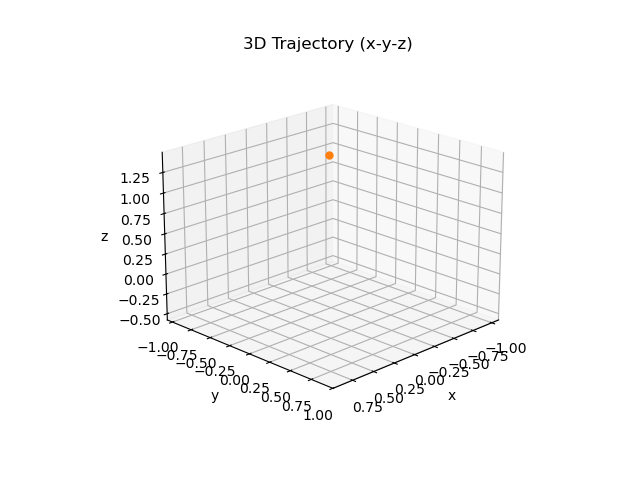

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, writers, FFMpegWriter

def animate_traj_3d(t, r_xyz, trail=200, interval=20, step=1,
                    save_path=None, show=True, close_fig=True, dpi=120,
                    elev=20, azim=45):
    t = np.asarray(t)
    r_xyz = np.asarray(r_xyz)
    x, y, z = r_xyz[:, 0], r_xyz[:, 1], r_xyz[:, 2]
    N = len(t)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.set_title("3D Trajectory (x-y-z)")
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
    ax.view_init(elev=elev, azim=azim)

    # axis limits (fixed)
    pad = 0.05
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    zmin, zmax = z.min(), z.max()
    dx, dy, dz = xmax-xmin, ymax-ymin, zmax-zmin

    def lim(lo, hi, d):
        if d == 0:
            eps = 1e-9 if lo == 0 else 1e-6 * abs(lo)
            return lo - eps, hi + eps
        return lo - pad*d, hi + pad*d

    ax.set_xlim(*lim(xmin, xmax, dx))
    ax.set_ylim(*lim(ymin, ymax, dy))
    ax.set_zlim(*lim(zmin, zmax, dz))

    # keep aspect roughly equal (matplotlib 3D has quirks, but this helps)
    max_range = max(dx, dy, dz) if max(dx, dy, dz) > 0 else 1.0
    cx, cy, cz = (xmin+xmax)/2, (ymin+ymax)/2, (zmin+zmax)/2
    ax.set_xlim(cx - max_range/2, cx + max_range/2)
    ax.set_ylim(cy - max_range/2, cy + max_range/2)
    ax.set_zlim(cz - max_range/2, cz + max_range/2)

    (line,) = ax.plot([], [], [], lw=1.5)
    (pt,) = ax.plot([], [], [], marker="o", markersize=5)

    frames = range(0, N, step)

    def init():
        line.set_data([], [])
        line.set_3d_properties([])
        pt.set_data([], [])
        pt.set_3d_properties([])
        return line, pt

    def update(i):
        i0 = 0 if trail is None else max(0, i - int(trail))
        line.set_data(x[i0:i+1], y[i0:i+1])
        line.set_3d_properties(z[i0:i+1])
        pt.set_data([x[i]], [y[i]])
        pt.set_3d_properties([z[i]])
        return line, pt

    ani = FuncAnimation(
        fig, update, frames=frames, init_func=init,
        interval=interval, blit=True,
        cache_frame_data=False
    )

    if save_path:
        fps = max(1, int(1000/interval))
        if save_path.lower().endswith(".mp4"):
            if writers.is_available("ffmpeg"):
                ani.save(save_path, writer=FFMpegWriter(fps=fps), dpi=dpi)
            else:
                gif_path = save_path[:-4] + ".gif"
                ani.save(gif_path, writer="pillow", fps=fps, dpi=dpi)
                print(f"[ffmpeg 없음] mp4 대신 gif 저장: {gif_path}")
        elif save_path.lower().endswith(".gif"):
            ani.save(save_path, writer="pillow", fps=fps, dpi=dpi)

    if show:
        plt.show()
    if close_fig:
        plt.close(fig)

    return ani

# Recover time to s, position to cm.
t_s = rateeq.sol.t * t0
x = rateeq.sol.r[0] * x0
y = rateeq.sol.r[1] * x0
z = rateeq.sol.r[2] * x0

plt.close("all")
ani = animate_traj_3d(
    t_s,
    np.column_stack([x, y, z]),
    trail=200,
    interval=20,
    step=50,
    save_path="traj3d.mp4",
    dpi=120
)

Now I have to simulate multi particle.  


In [ ]:
import pathos
from pylcp.common import progressBar

if hasattr(rateeq, "sol"):
    del rateeq.sol

def generate_solution():
    r0 = sampling.sampling(x_limit = wa, y_limit = wa, z_limit = wb, Natom = 1)
    rateeq.set_initial_position(r0)
    v0 = Boltzmann_dist.vel_Boltzmann(T = 300, m = atom.mass)
    # Set velocity as unitless.
    v0 = v0 * t0 / x0
    rateeq.set_initial_velocity(v0)
    
    # uniform over ground manifold as a sane start:
    N0 = np.zeros(rateeq.hamiltonian.n)
    ng = rateeq.hamiltonian.ns[0]          # ground manifold size (usually first block)
    N0[:ng] = 1/ng
    rateeq.set_initial_pop(N0)
    
    sol = rateeq.evolve_populations([0, 5e3], rtol=1e-6, atol=1e-9)  # time in pylcp units
    Nss = sol.y[:, -1]
    Nss /= Nss.sum()
    rateeq.set_initial_pop(Nss)
    
    rateeq.evolve_motion([0, tlen],
                    atol = 1e-6, rtol = 1e-4,
                    freeze_axis = [False,False,False],
                    progress_bar=True,
                    boundaries=[wa, wa, wb], 
                    success_event = success_capture
                    )
    return rateeq.sol

Natoms = 1
chunksize = 1
sols = []
progress = progressBar()
for jj in range(int(Natoms/chunksize)):
    with pathos.pools.ProcessPool(nodes = 4) as pool:
        sols += pool.map(generate_solution(), range(chunksize))
    progress.update((jj+1)/int(Natoms/chunksize))

I want to save it

In [ ]:
import h5py
import datetime

now = datetime.datetime.now()
formatted_now = now.strftime("%m-%d %H:%M")
file_name = formatted_now + "multi_atom_simul_test"
# sols is a list of sol which contains
#   1. t: integration times found by solve_ivp (list)
#   2. N: population vs. time (array_like, (N,)
#   3. v: atomic velocity (array_like, (3,)
#   4. r: atomic position (array_like, (3,)
with h5py.File(file_name + '.hdf5', 'w') as f:
    for Num in range(Natoms):
        profile = f.create_group(f'evolve_motion_{Num}')
        profile.create_dataset('t', data=sols[Num].t)
        profile.create_dataset('N', data=sols[Num].N)
        profile.create_dataset('v', data=sols[Num].v)
        profile.create_dataset('r', data=sols[Num].r)
    
